In [12]:
from osgeo import gdal,ogr,osr
import os
import numpy as np
import matplotlib.pyplot as plt
#import spectral
#import rasterio
#import spectral.io.envi as envi
#import json
import math
from math import sqrt
import pandas as pd
import geopandas as gpd
import affine
from affine import Affine
import helper_functions

In [13]:
# Path to the external SSD
# external_ssd_path = '/Volumes/Desk SSD'
external_ssd_path = '/Volumes/T9'
source_folder_name = "sensor_validation/"
source_folder_path = os.path.join(external_ssd_path,source_folder_name)
subzone = "subzone_c"
source_folder_subzones = ["subzone_c","subzone_d","subzone_e"]

# Check if the external SSD is mounted
if os.path.exists(external_ssd_path):
    print(f"External SSD mounted at: {external_ssd_path}")

External SSD mounted at: /Volumes/T9


In [14]:
flightstrips, hsi_img_object, plot_site_shapefile = helper_functions.get_subzone_objects(source_folder_path, subzone)

HSI Source folder path: /Volumes/T9/sensor_validation/subzone_c/hsi
Plots Source folder path: /Volumes/T9/sensor_validation/subzone_c/plots


In [38]:

hdr_source_folder_path = os.path.join(external_ssd_path,source_folder_name,subzone,"hsi","ang20170709t224839rfl","ang20170709t224839_corr_v2p9_img.hdr")
hdr_source_folder_path

'/Volumes/T9/sensor_validation/subzone_c/hsi/ang20170709t224839rfl/ang20170709t224839_corr_v2p9_img.hdr'

In [39]:
# Read header file and get the metadata
def read_envi_header(file_path):
    metadata = {}
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            if " = " in line:
                key, value = line.strip().split(" = ", 1)
                metadata[key.strip()] = value.strip().strip('{}')
            elif line.strip().endswith('}'):
                # Multi-line metadata
                key, value = lines[lines.index(line) - 1].strip().split(" = ", 1)
                metadata[key.strip()] += line.strip().strip('{}')
    return metadata

metadata = read_envi_header(hdr_source_folder_path)

In [40]:
metadata

{'description': 'AVIRIS-NG Measured Radiances in uW nm-1 cm-2 sr-1',
 'samples': '655',
 'lines': '3883',
 'bands': '425',
 'header offset': '0',
 'file type': 'ENVI',
 'data type': '4',
 'interleave': 'bil',
 'byte order': '0',
 'map info': ' UTM , 1 , 1 , 578244.239511 , 7915397.83165 , 5.1 , 5.1 , 4 , North , WGS-84 , units=Meters , rotation=42.0000000 ',
 'crosstrack scatter file': '/home/winstono/isat-ang2017/ang/cal/data/20170125_via_ang20160925t182412_crf',
 'wavelength units': 'Nanometers',
 'flat field file': '/home/winstono/isat-ang2017/ang/cal/data/20170320_ang20170313_BLUSS_avg_rows300-340_ff',
 'spectral scatter file': '/home/winstono/isat-ang2017/ang/cal/data/20170125_via_ang20160925t182412_srf',
 'wavelength file': '/home/winstono/isat-ang2017/ang/cal/data/20170320_ang20170228_wavelength_fit_full.txt',
 'wavelength': ' 376.86 , 381.87 , 386.88 , 391.89 , 396.89 , 401.9 , 406.91 , 411.92 , 416.93 , 421.94 , 426.95 , 431.96 , 436.96 , 441.97 , 446.98 , 451.99 , 457.0 , 462

In [31]:

# Extract metadata
metadata = hsi_img_object["ang20170709t224839rfl"].GetMetadata()

# Assuming 'DATE_ACQUIRED' and 'TIME_ACQUIRED' are the keys in the metadata
date_acquired = metadata.get('DATE_ACQUIRED')
time_acquired = metadata.get('TIME_ACQUIRED')

# Display the date and time
print(f"Date Acquired: {date_acquired}")
print(f"Time Acquired: {time_acquired}")

Date Acquired: None
Time Acquired: None


In [16]:
for flightstrip in flightstrips:
    # read a few key properties of the image
    nbands = hsi_img_object[flightstrip].RasterCount
    ncols = hsi_img_object[flightstrip].RasterXSize
    nrows = hsi_img_object[flightstrip].RasterYSize

    print("\n".join(["Flightstrip:\t"+str(flightstrip),"Bands:\t"+str(nbands),"Cols (x-axis):\t"+str(ncols),"Rows (y-axis):\t"+str(nrows)]))
    print("-------------------------------------")

Flightstrip:	ang20170709t224839rfl
Bands:	425
Cols (x-axis):	655
Rows (y-axis):	3883
-------------------------------------
Flightstrip:	ang20170714t235124rfl
Bands:	425
Cols (x-axis):	652
Rows (y-axis):	3614
-------------------------------------
Flightstrip:	ang20190706t234547rfl
Bands:	425
Cols (x-axis):	1041
Rows (y-axis):	3912
-------------------------------------
Flightstrip:	ang20190706t235120rfl
Bands:	425
Cols (x-axis):	647
Rows (y-axis):	3798
-------------------------------------
Flightstrip:	ang20190712t212208rfl
Bands:	425
Cols (x-axis):	957
Rows (y-axis):	3837
-------------------------------------
Flightstrip:	ang20190712t212749rfl
Bands:	425
Cols (x-axis):	662
Rows (y-axis):	3751
-------------------------------------


In [17]:
# Get the layer from the shapefile
layer = plot_site_shapefile.GetLayer()

# Create an empty list to store feature attributes
attribute_list = []

# Get field names (attribute names)
layer_definition = layer.GetLayerDefn()
field_names = [layer_definition.GetFieldDefn(i).GetName() for i in range(layer_definition.GetFieldCount())]

# Iterate over the features in the shapefile
for feature in layer:
    # Extract the attribute values for the feature
    attributes = [feature.GetField(field) for field in field_names]
    attribute_list.append(attributes)

# Create a pandas DataFrame with the extracted attributes
df = pd.DataFrame(attribute_list, columns=field_names)

# Show the DataFrame (tabular format of the shapefile attributes)
print(df)

# Optionally, display the first few rows
#df.head()

  C2_plot_jp Field_rele Modified_r              Date__year  \
0       None       1304       1304  1972, 1999, 2008, 2024   
1       None       1303       1303  1972, 1999, 2008, 2023   
2       None        208        208  1972, 1999, 2008, 2011   
3       None        206        206  1972, 1999, 2008, 2010   

               Year_plot_                                           Dataset  \
0  1972, 1999, 2008, 2024  Barrow IBP (Webber 1978, Villarreal et al. 2012)   
1  1972, 1999, 2008, 2023  Barrow IBP (Webber 1978, Villarreal et al. 2012)   
2  1972, 1999, 2008, 2011  Barrow IBP (Webber 1978, Villarreal et al. 2012)   
3  1972, 1999, 2008, 2010  Barrow IBP (Webber 1978, Villarreal et al. 2012)   

                                          Surveyed_b       lat        lon  \
0  Patrick Webber, Sandra Villarreal & Craig Tweedie  71.29462  -156.6882   
1  Patrick Webber, Sandra Villarreal & Craig Tweedie  71.29456  -156.6891   
2  Patrick Webber, Sandra Villarreal & Craig Tweedie  71.29430

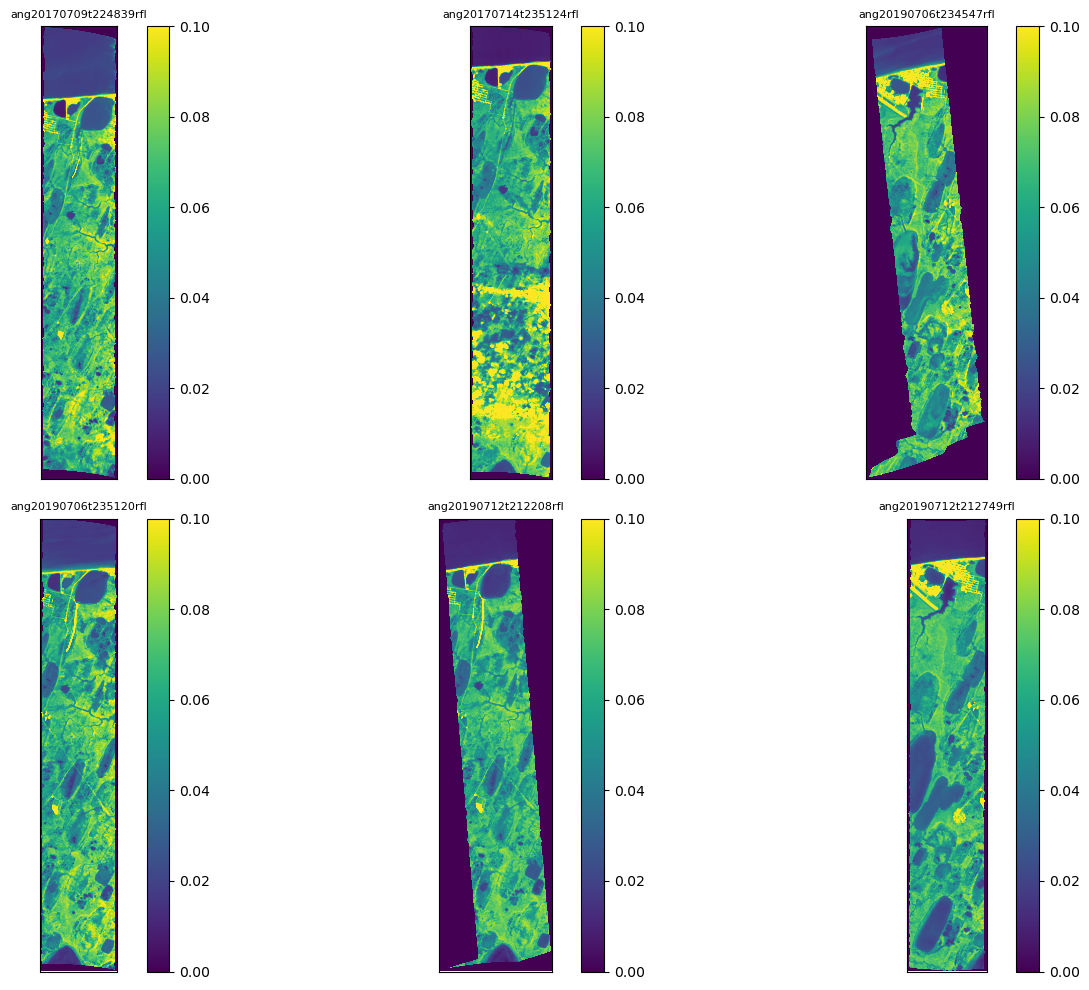

In [43]:
plot_strips = True

if plot_strips:
    # Number of images
    num_images = len(hsi_img_object)

    # Define the number of rows and columns for the subplot grid (e.g., 2 rows, 3 columns for 6 images)
    n_cols = 3  # Adjust this based on how you want to display them
    n_rows = (num_images + n_cols - 1) // n_cols  # Calculate required rows

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust figsize to fit all images

    # Flatten the axes array if there's more than 1 row
    axes = axes.flatten()

    # Iterate over folder names and GDAL objects in the dictionary
    for idx, (folder_name, gdal_object) in enumerate(hsi_img_object.items()):
        if gdal_object:
            # Read the 57th band (red band)
            img_red = gdal_object.GetRasterBand(57).ReadAsArray()

            # Plot the image in the corresponding subplot
            ax = axes[idx]
            ax.imshow(img_red, vmin=0, vmax=0.1)
            ax.set_title(f"{folder_name}", fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])

            # Add a colorbar to each subplot (optional)
            fig.colorbar(ax.imshow(img_red, vmin=0, vmax=0.1), ax=ax)
        else:
            ax.set_visible(False)  # Hide empty subplots if there are fewer images than subplots

    # Adjust layout to prevent overlapping titles and colorbars
    plt.tight_layout()

    # Show the plot with all images
    plt.show()


In [19]:
flightstrip_transformation = {}

for flightstrip in flightstrips:
    # Print the EPSG code
    hs_crs = helper_functions.return_hsi_projection(hsi_img_object[flightstrip])
    #print(f"EPSG Code Hyperspectral Image {flightstrip}: {hs_crs}")
    # shapefiles have a nested structure: layer(s) -> feature(s) -> geometry
    
    lyr = plot_site_shapefile.GetLayer() # get the only layer in the shapefile
    feat = lyr.GetFeature(1)          # get the first feature in the layer (1 feature per site)
    geom = feat.GetGeometryRef()      # get the feature's geometry

    # get transform for decimal degrees
    from_srs = lyr.GetSpatialRef()                                         # get shapefile srs def
    to_srs = osr.SpatialReference()                                        # init ogr srs object
    to_srs.ImportFromEPSG(int(hs_crs))                                     # import wgs84 srs def
    xytransform = osr.CoordinateTransformation(from_srs,to_srs)            # get transform object

    
    # get UTM and lat/long coordinates for each of the sites
    utm_coordinate_pairs = {}
    ll_coordinate_pairs = {}

    for feature in lyr:
        geom = feature.GetGeometryRef()                                    # get site geometry
        utm_coordinate_pairs[feature['Modified_r']] = (geom.GetX(), geom.GetY()) # get x,y utm coordinates 
        geom.Transform(xytransform)                                        # to wgs84
        ll_coordinate_pairs[feature['Modified_r']] = (geom.GetX(), geom.GetY())  # get lon, lat

    affine_transform = affine.Affine.from_gdal(*hsi_img_object[flightstrip].GetGeoTransform())     # affine forward transform
    inverse_transform = ~affine_transform

    plot_site_pixel_coordinates = pd.DataFrame(columns = ["Subzone", "Flightstrip", "Modified_r", "lon", "lat", "pixel_x", "pixel_y"])

    for site, coords in ll_coordinate_pairs.items():
        lon, lat = coords
        px, py = inverse_transform * (lon, lat)                                    # apply to x,y coordinates
        px, py = round(px), round(py)                                  # get new x,y as integers
        plot_site_pixel_coordinates = plot_site_pixel_coordinates._append({"Subzone" : subzone, "Flightstrip" : flightstrip, "Modified_r" : site, "lon" : lon, "lat" : lat, "pixel_x" : px, "pixel_y" : py},
            ignore_index = True)

    flightstrip_transformation[flightstrip] = {
        "utm_coordinate_pairs": utm_coordinate_pairs,
        "ll_coordinate_pairs": ll_coordinate_pairs,
        "plot_site_pixel_coordinates": plot_site_pixel_coordinates
    }

/var/folders/3m/0hcxmtys0jj01y_svh59k5fm0000gn/T/ipykernel_6867/90617595.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_site_pixel_coordinates = plot_site_pixel_coordinates._append({"Subzone" : subzone, "Flightstrip" : flightstrip, "Modified_r" : site, "lon" : lon, "lat" : lat, "pixel_x" : px, "pixel_y" : py},
/var/folders/3m/0hcxmtys0jj01y_svh59k5fm0000gn/T/ipykernel_6867/90617595.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_site_pixel_coordinates = plot_site_pixel_coord

In [20]:
'''
for flightstrip in flightstrips:
    print(flightstrip_transformation[flightstrip]["plot_site_pixel_coordinates"])
    print("--------------------------------------------")
'''

'\nfor flightstrip in flightstrips:\n    print(flightstrip_transformation[flightstrip]["plot_site_pixel_coordinates"])\n    print("--------------------------------------------")\n'

In [21]:
for flightstrip in flightstrips:
    # Extracting metadata keys and values
    metadata_keys = hsi_img_object[flightstrip].GetMetadata().keys()
    metadata_values = hsi_img_object[flightstrip].GetMetadata().values()


    # Lists of band numbers and band centers
    band_numbers = [
        int(key.split("_")[1])
        for key in metadata_keys
        if key != "wavelength_units"
    ]

    band_centers = [
        float(value.split(" ")[0])
        for value in metadata_values
        if value != "Nanometers"
    ]

    # Classify each band center
    em_regions = [helper_functions.classify_band(b) for b in band_centers]


    # get the reflectance values of the site (careful: these values are already sorted --> add to df after sort)
    #testsite1_reflectance = img_open.ReadAsArray(px1,py1,1,1).flatten().tolist()
    #testsite2_reflectance = img_open.ReadAsArray(px2,py2,1,1).flatten().tolist()


    # Function to get reflectance for each site
    def get_site_reflectance(px, py):
        reflectance = hsi_img_object[flightstrip].ReadAsArray(px,py,1,1).flatten()
        return reflectance

    # Apply the function to each row and add the result as a new column
    flightstrip_transformation[flightstrip]["plot_site_pixel_coordinates"]["reflectance"] = flightstrip_transformation[flightstrip]["plot_site_pixel_coordinates"].apply(lambda row: get_site_reflectance(row["pixel_x"], row["pixel_y"]), axis=1)


In [27]:
flightstrip_transformation["ang20170709t224839rfl"]

{'utm_coordinate_pairs': {'1304': (-156.68821489999996, 71.2946219),
  '1303': (-156.6891071, 71.2945664),
  '208': (-156.68648219999997, 71.2942973),
  '206': (-156.68669929999996, 71.2946814)},
 'll_coordinate_pairs': {'1304': (582729.6015380382, 7911837.503997706),
  '1303': (582697.9234555771, 7911830.097791158),
  '208': (582792.9657120816, 7911803.694585107),
  '206': (582783.5616735986, 7911846.20963549)},
 'plot_site_pixel_coordinates':      Subzone            Flightstrip Modified_r            lon           lat  \
 0  subzone_c  ang20170709t224839rfl       1304  582729.601538  7.911838e+06   
 1  subzone_c  ang20170709t224839rfl       1303  582697.923456  7.911830e+06   
 2  subzone_c  ang20170709t224839rfl        208  582792.965712  7.911804e+06   
 3  subzone_c  ang20170709t224839rfl        206  582783.561674  7.911846e+06   
 
   pixel_x pixel_y                                        reflectance  
 0     186    1107  [0.010031244, 0.009875436, 0.008165414, 0.0086...  
 1    

In [22]:
'''
for flightstrip in flightstrips:
    print(flightstrip_transformation[flightstrip]["plot_site_pixel_coordinates"])
'''

'\nfor flightstrip in flightstrips:\n    print(flightstrip_transformation[flightstrip]["plot_site_pixel_coordinates"])\n'

In [23]:
# Initialize an empty list to store the DataFrames
combined_dataframes = []

# Loop through the list and accumulate the DataFrames
for flightstrip in flightstrips:
    combined_dataframes.append(flightstrip_transformation[flightstrip]["plot_site_pixel_coordinates"])

# Concatenate all DataFrames at once
combined_df = pd.concat(combined_dataframes, ignore_index=True)

# clean the data a little bit: -9999 means no measurement could be made. therefor I replace the value with a nan.
combined_df['reflectance'] = combined_df['reflectance'].apply(lambda x: np.where(x == -9999, np.nan, x))

# for easier viewing: sort the dataframe
combined_df = combined_df.sort_values(by=['Modified_r'])

combined_df.head(25)

,Subzone,Flightstrip,Modified_r,lon,lat,pixel_x,pixel_y,reflectance
1,subzone_c,ang20170709t224839rfl,1303,582697.923456,7.911830e+06,181,1104,"[0.009918294, 0.007799807, 0.007905166, 0.0120..."
21,subzone_c,ang20190712t212749rfl,1303,582697.923456,7.911830e+06,644,812,"[0.09066007, 0.07988939, 0.075758435, 0.069619..."
5,subzone_c,ang20170714t235124rfl,1303,582697.923456,7.911830e+06,191,797,"[0.0074635395, 0.0042541777, 0.005983507, 0.00..."
17,subzone_c,ang20190712t212208rfl,1303,582697.923456,7.911830e+06,218,911,"[0.06904852, 0.063784696, 0.060584027, 0.05888..."
9,subzone_c,ang20190706t234547rfl,1303,582697.923456,7.911830e+06,734,797,"[0.103871346, 0.09084848, 0.08651532, 0.076982..."
13,subzone_c,ang20190706t235120rfl,1303,582697.923456,7.911830e+06,138,926,"[0.061084174, 0.057002794, 0.053789023, 0.0528..."
0,subzone_c,ang20170709t224839rfl,1304,582729.601538,7.911838e+06,186,1107,"[0.010031244, 0.009875436, 0.008165414, 0.0086..."
20,subzone_c,ang20190712t212749rfl,1304,582729.601538,7.911838e+06,649,815,"[0.10638162, 0.09305268, 0.08615828, 0.0799184..."
4,subzone_c,ang20170714t235124rfl,1304,582729.601538,7.911838e+06,197,800,"[0.006405735, -0.0026574247, 0.0028126906, 0.0..."
8,subzone_c,ang20190706t234547rfl,1304,582729.601538,7.911838e+06,739,799,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [24]:
# get the unique values for the plotsite names / identifiers
unique_plotsite_identifier_values = combined_df['Modified_r'].unique()

dataframe_array = {}

# DataFrame describing bands
bands = pd.DataFrame({
    "Band number": band_numbers,
    "Band center (nm)": band_centers,
    "EM region": em_regions
}, index=band_numbers).sort_index()

for plotsite in unique_plotsite_identifier_values:
    df_location = bands
    # Iterate over rows
    for row in combined_df[combined_df['Modified_r'] == plotsite].itertuples():
        df_location[f"{row.Flightstrip}_Reflectance"] = row.reflectance

    dataframe_array[f'df_{plotsite}'] = df_location

### Create a plot with noise bands removed

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


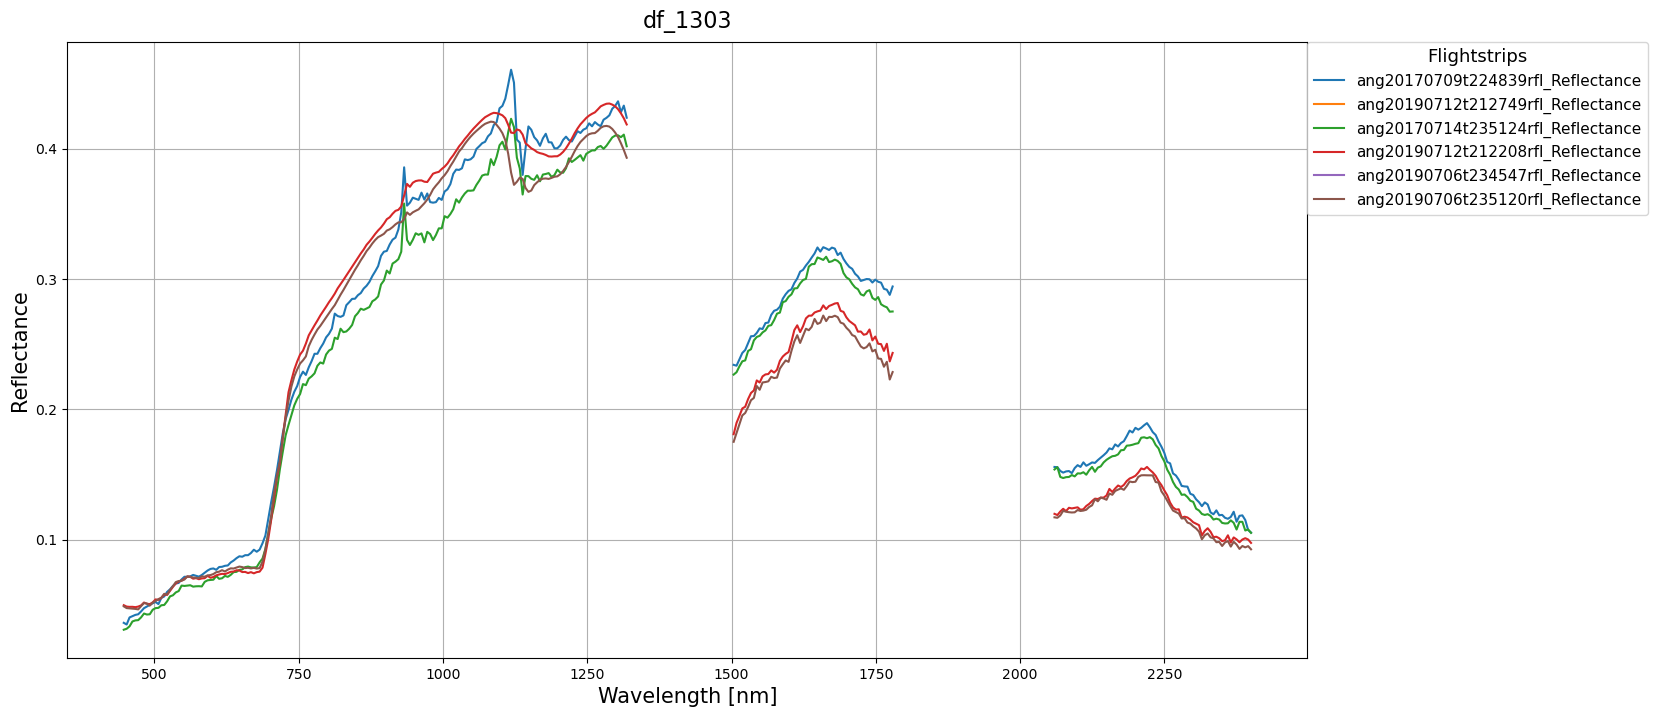

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


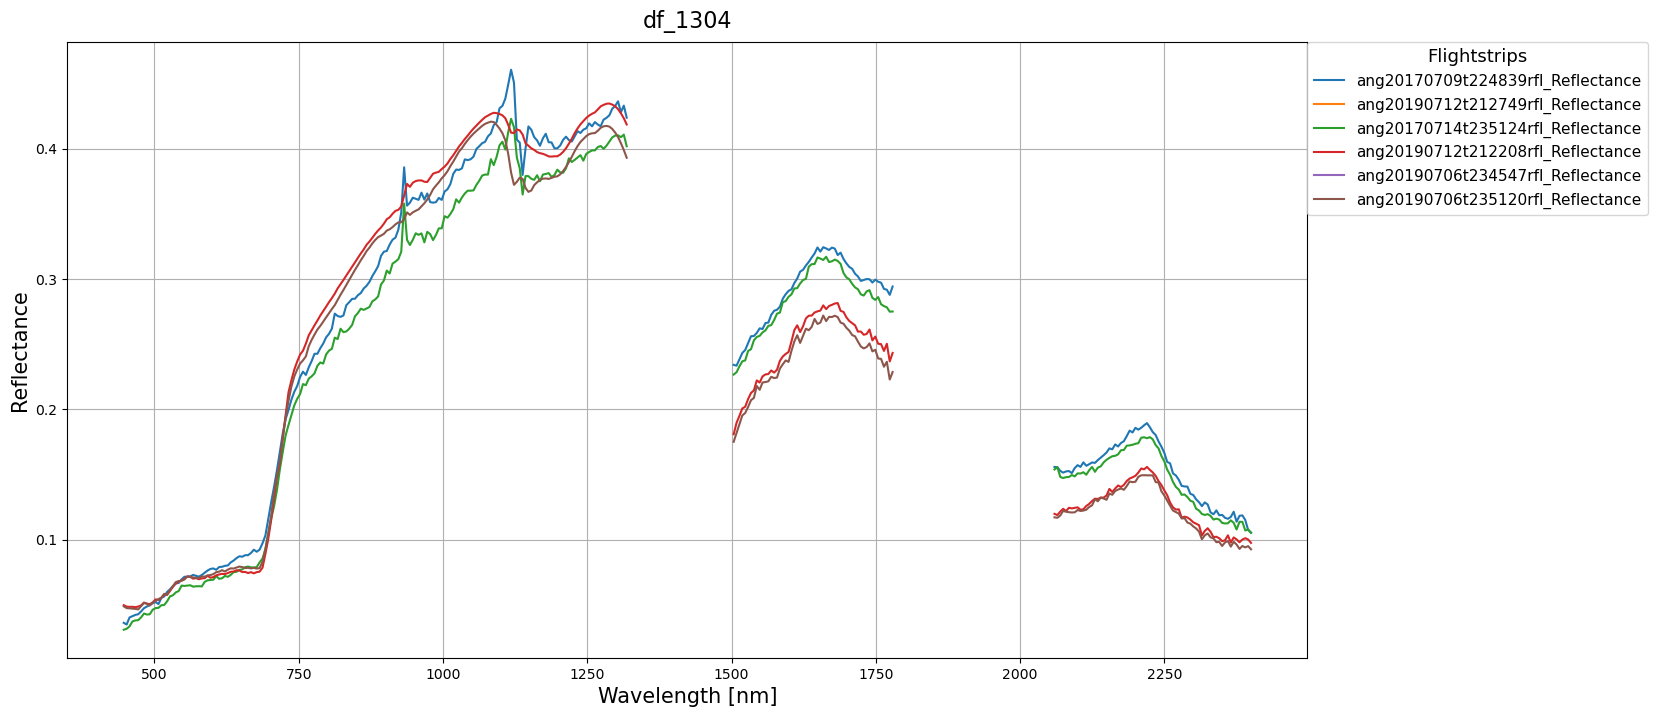

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


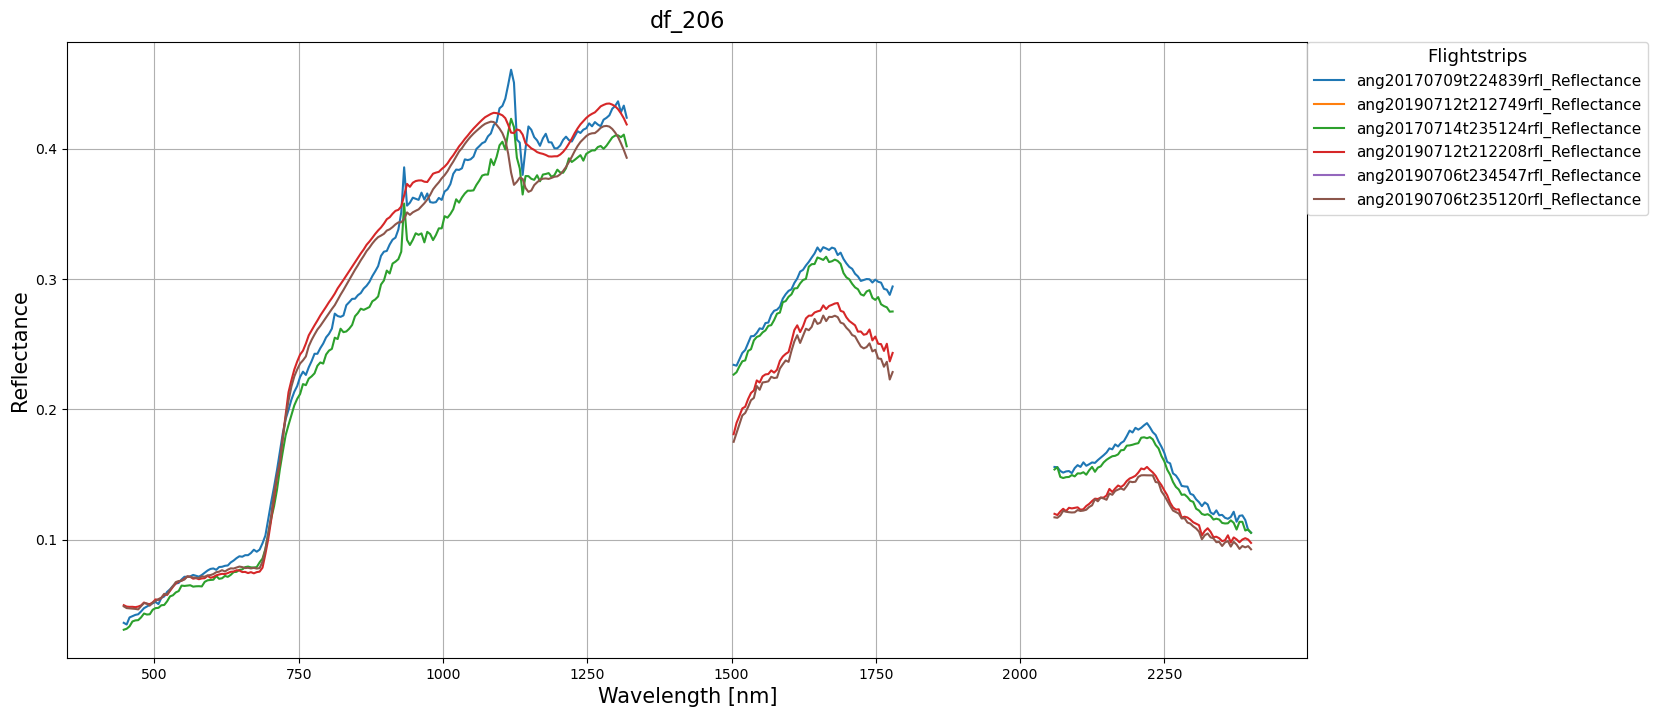

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


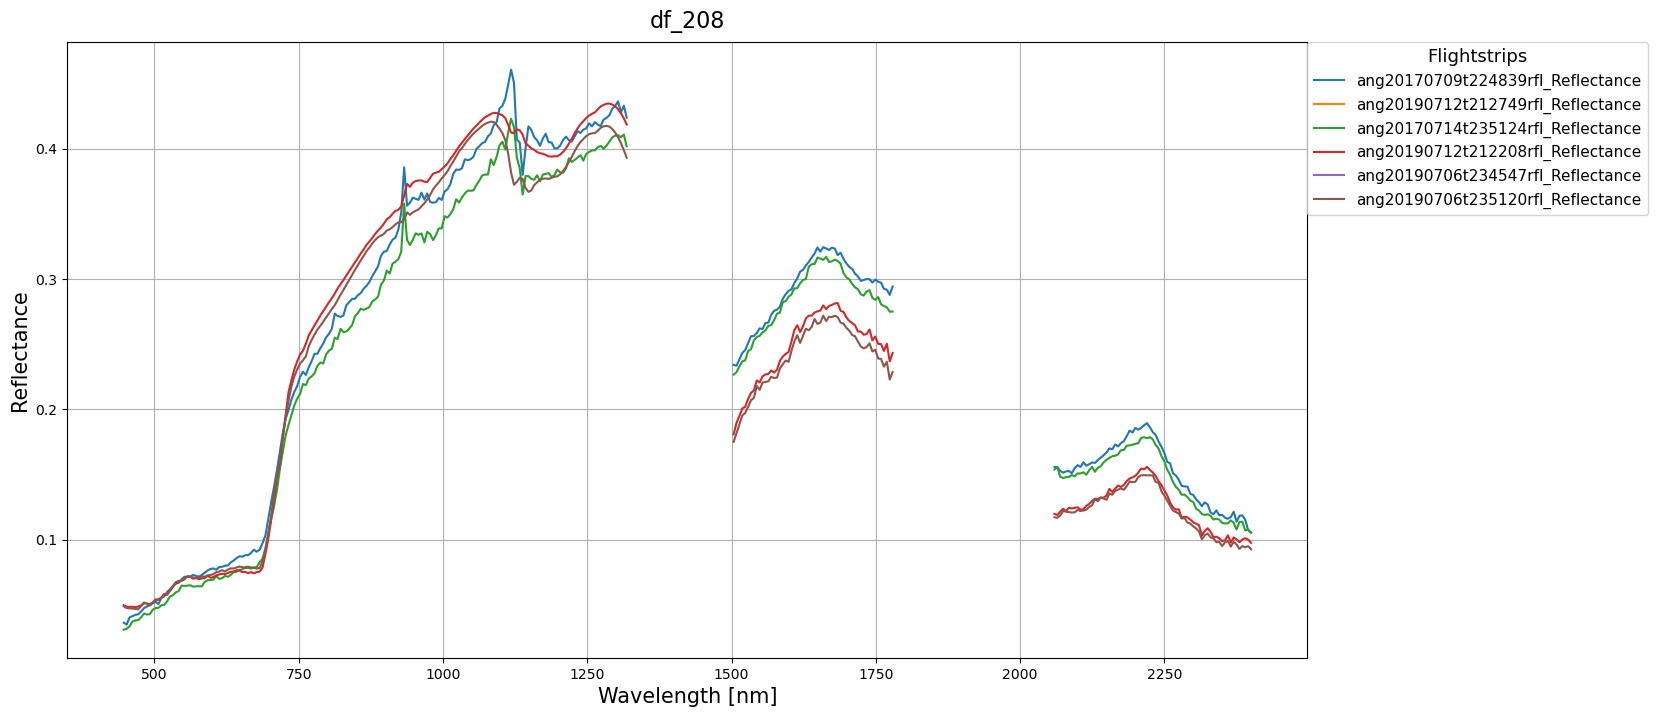

In [25]:
bblist = np.ones((425,))
bblist[0:14] = 0
bblist[189:225] = 0
bblist[281:336] = 0
bblist[405:] = 0

titlefont = {'fontsize':16,'fontweight':2,
             'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [16, 8]

for plotsite in dataframe_array:
    for series_name, series in dataframe_array[plotsite].items():
        if(series_name == "Band center (nm)"):
            wavelength_flightstrip = series
            #print(series)
        elif("_Reflectance" in series_name):
            pixel_flightstrip = dataframe_array[plotsite][series_name]
            pixel_flightstrip = np.reshape(pixel_flightstrip,(425))
            pixel_flightstrip[bblist == 0] = np.nan
            pixel_flightstrip[pixel_flightstrip==-9999] = np.nan
            plt.plot(wavelength_flightstrip, pixel_flightstrip,  label = series_name)
            #print(f"Plotsite {plotsite} flightstrip {series_name}")
        
        plt.xlabel ( 'Wavelength [nm]', fontsize=15)
        #plt.ylim(y_min, y_max)
        plt.ylabel('Reflectance', fontsize=15)
        plt.title(plotsite, fontdict = titlefont, pad = 10)
        plt.grid()
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Flightstrips', title_fontsize='13', fontsize='11', borderaxespad=0.)

    plt.show()


